## kaggle链接：
### https://www.kaggle.com/code/czy111/wgan-div/edit

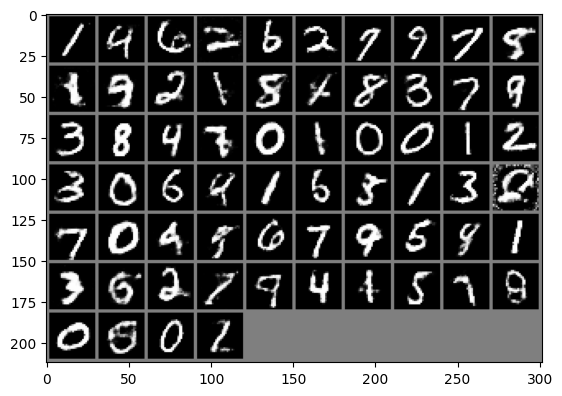

[Epoch 199/200] [Batch 745/938] [D loss: -0.734503] [G loss: -1.074544]
[Epoch 199/200] [Batch 750/938] [D loss: -0.415794] [G loss: -1.098506]
[Epoch 199/200] [Batch 755/938] [D loss: -0.025023] [G loss: -1.401967]
[Epoch 199/200] [Batch 760/938] [D loss: -0.322866] [G loss: -1.082702]
[Epoch 199/200] [Batch 765/938] [D loss: -0.303102] [G loss: -1.054927]
[Epoch 199/200] [Batch 770/938] [D loss: -0.470044] [G loss: -1.079767]
[Epoch 199/200] [Batch 775/938] [D loss: -0.462451] [G loss: -0.932494]
[Epoch 199/200] [Batch 780/938] [D loss: -0.493795] [G loss: -0.995181]
[Epoch 199/200] [Batch 785/938] [D loss: -0.485848] [G loss: -1.288258]
[Epoch 199/200] [Batch 790/938] [D loss: -0.232507] [G loss: -1.364451]
[Epoch 199/200] [Batch 795/938] [D loss: -0.428162] [G loss: -1.141402]
[Epoch 199/200] [Batch 800/938] [D loss: -0.363746] [G loss: -1.174103]
[Epoch 199/200] [Batch 805/938] [D loss: -0.351159] [G loss: -1.503693]
[Epoch 199/200] [Batch 810/938] [D loss: -0.577251] [G loss: -1.

In [1]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
import torchvision
import matplotlib.pyplot as plt
from IPython.display import clear_output
os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_args([])
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


k = 2
p = 6


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

batches_done = 0
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

            if batches_done % 200 == 0:
                clear_output()
                img=torchvision.utils.make_grid(fake_imgs,nrow=10,padding=2)
                
                img=img.detach().cpu().numpy().transpose(1, 2, 0)
                plt.imshow(img*0.5+0.5)
                plt.show()
                #save_image(fake_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += opt.n_critic


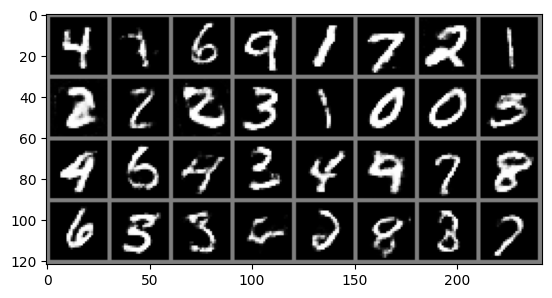

In [3]:
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
fake_imgs = generator(z)
img=torchvision.utils.make_grid(fake_imgs,nrow=8,padding=2)
                
img=img.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(img*0.5+0.5)
plt.show()